In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [2]:
cd ../../../Noah

/mnt/pesaranlab/People/Capstone_students/Noah


In [ ]:
moving_files_train = []
moving_files_val = []
for ind, f in enumerate(os.listdir('data/move/')):
    x = np.load('data/move/'+f)
    l = np.split(x,62)
    if ('0413' in f) or ('0414' in f):
        for arr in l:
            moving_files_val.append(arr)
    else:
        for arr in l:
            moving_files_train.append(arr)
        
sleeping_files_train = []
sleeping_files_val = []
for ind, f in enumerate(os.listdir('data/sleep/')):
    x = np.load('data/sleep/'+f)
    l = np.split(x,62)
    if ('0413' in f) or ('0414' in f):
        for arr in l:
            sleeping_files_val.append(arr)
    else:
        for arr in l:
            sleeping_files_train.append(arr)

In [4]:
len(moving_files_train), len(moving_files_val), len(sleeping_files_train), len(sleeping_files_val)

(122078, 38750, 755656, 121334)

In [5]:
import random
diff_train = len(sleeping_files_train)-len(moving_files_train)
for i in range(diff_train):
    ind = random.randint(1,len(moving_files_train)-1)
    x= moving_files_train[ind]
    moving_files_train.append(x)

diff_val = len(sleeping_files_val)-len(moving_files_val)
for i in range(diff_val):
    ind = random.randint(1,len(moving_files_val)-1)
    x= moving_files_val[ind]
    moving_files_val.append(x)

In [6]:
len(moving_files_train), len(moving_files_val), len(sleeping_files_train), len(sleeping_files_val)

(755656, 121334, 755656, 121334)

In [7]:
torch.tensor([0])

tensor([0])

In [8]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' , moving_files_train=moving_files_train, sleeping_files_train=sleeping_files_train, moving_files_val=moving_files_val, sleeping_files_val=sleeping_files_val):
        self.train_files = moving_files_train+sleeping_files_train
        self.val_files = moving_files_val+sleeping_files_val
        self.moving_files_train_labels = [1]*len(moving_files_train)
        self.moving_files_val_labels = [1]*len(moving_files_val)
        self.sleeping_files_train_labels = [0]*len(sleeping_files_train)
        self.sleeping_files_val_labels = [0]*len(sleeping_files_val)
        self.train_labels = self.moving_files_train_labels + self.sleeping_files_train_labels
        self.val_labels = self.moving_files_val_labels + self.sleeping_files_val_labels
        if mode == 'train':
            self.files = self.train_files
            self.labels = self.train_labels
        elif mode == 'val':
            self.files = self.val_files
            self.labels = self.val_labels
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        spec = torch.from_numpy(self.files[idx])
        label = torch.tensor([self.labels[idx]])
        return  spec, label

In [9]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='val')

In [10]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

In [11]:
len(train_dataset), len(train_loader)

(1511312, 47229)

In [12]:
len(valid_dataset), len(val_loader)

(242668, 7584)

## Dumb CNN

In [14]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x

In [15]:
import torch
print(torch.__version__)

1.6.0


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [18]:
def train(epoch):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device).float().flatten()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
#             if epoch == 0:
#                 bad_data[batch_idx] = data
            
            continue
        
        preds = model(data)
#         print(preds.shape, labels.shape)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    
    return(epoch_loss)

In [19]:
def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            preds = model(data)
            loss = criterion(preds, labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        return epoch_loss

In [19]:
epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 0.33252283930778503
Val loss for epoch 0: 0.9646086692810059
Train loss for epoch 1: 0.2938613295555115
Val loss for epoch 1: 1.0439711809158325
Train loss for epoch 2: 0.28255271911621094
Val loss for epoch 2: 0.9620605707168579
Train loss for epoch 3: 0.27676329016685486
Val loss for epoch 3: 0.9630476236343384
Train loss for epoch 4: 0.2734138071537018
Val loss for epoch 4: 0.9776914715766907
Train loss for epoch 5: 0.27089443802833557
Val loss for epoch 5: 1.0004366636276245
Train loss for epoch 6: 0.2693677246570587
Val loss for epoch 6: 0.9771832227706909
Train loss for epoch 7: 0.2678665518760681
Val loss for epoch 7: 1.0553696155548096
Train loss for epoch 8: 0.2669597566127777
Val loss for epoch 8: 1.0475925207138062
Train loss for epoch 9: 0.2662821412086487
Val loss for epoch 9: 1.0434954166412354


KeyboardInterrupt: 

In [20]:
model.conv1.weight.data.shape

torch.Size([2, 1, 3, 3])

In [22]:
w = model.conv1.weight.data
w_chan0 = w[0]
w_chan1 = w[1]

In [23]:
w_chan0.shape

torch.Size([1, 3, 3])

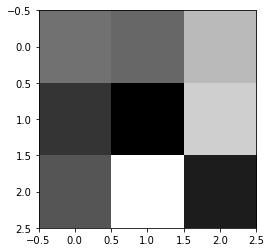

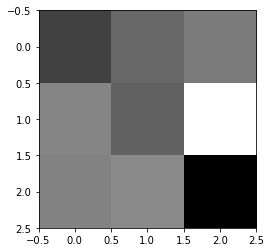

In [35]:
for i in range(len(model.conv1.weight.data)):
#     plt.figure(figsize=(2,2))
    plt.imshow(model.conv1.weight.data[i][0].cpu(), cmap = 'gray')
    plt.show()

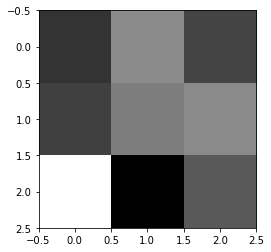

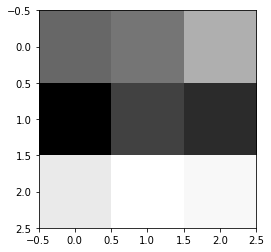

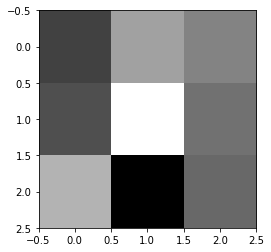

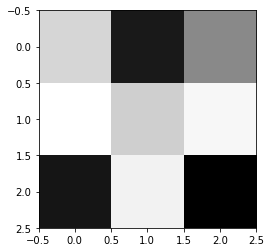

In [34]:
for i in range(len(model.conv2.weight.data)):
    plt.imshow(model.conv2.weight.data[i][0].cpu(), cmap = 'gray')
    plt.show()

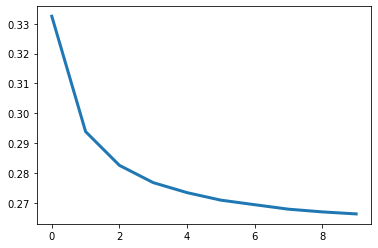

In [36]:
plt.plot(training_losses,linewidth = 3)

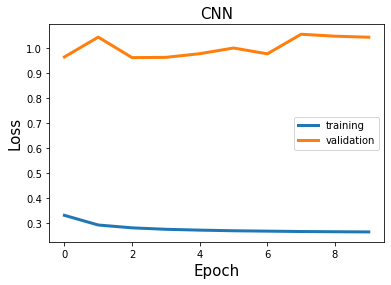

In [37]:
plt.title("CNN", fontsize = 15)
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.plot(training_losses,linewidth = 3,label='training')
plt.plot(val_losses, linewidth = 3,label='validation')
plt.legend()

# Dropout CNN

In [21]:
class CNN_dropout(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN_dropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x = self.dropout(relu(self.conv1(x)))
        x = self.dropout(relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x

In [ ]:
model = CNN_dropout().to(device)

epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 0.7097359895706177
Val loss for epoch 0: 0.7121326923370361


## MLP

In [49]:
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x = relu(self.fc1(x))
        x = self.dropout(x)
        x = relu(self.fc2(x)).flatten()
        x = self.sigmoid(x)
        return x

In [50]:
model = MLP().to(device)

In [ ]:
epochs = []
training_losses = []
val_losses = []
for epoch in range(num_epochs):
    avg_train_loss = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 0.6984504461288452
Val loss for epoch 0: 0.6993554830551147
Train loss for epoch 1: 0.6984370350837708
Val loss for epoch 1: 0.6993554830551147
